# Apache Spark - Analyzing Food Insecurity in NYC using KeyFoods Price Catalogs: Part 2

We continue our efforts in analyzing food insecurity in NYC. In the previous attemps (https://github.com/lau-allen/foodinsecurity-analysis.git), we didn't see a relationship between star ratings for grocery stores compared to food insecurity level in the community district. However, we were only looking at Key Food stores. We would like to extend the study to all grocery stores in NYC. To do that, we have collect store ratings data through [Google Places API](https://developers.google.com/maps/documentation/places/web-service/overview) with respect to supermarket stores. This results in over 7000 locations, but we are only interested in [1200 stores](https://nyu.carto.com/u/huyvo/builder/12ad7126-f9f4-480e-a921-0fab040d209e/) with star ratings. Unfortunately, we also do not see a clear relationship in this case, as shown in the plot below.

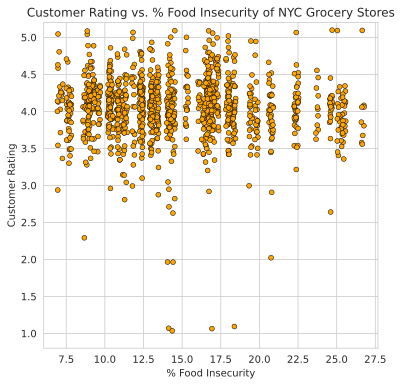

In [ ]:
#@title


Our next objective is to determine the distance people traveled to grocery stores by census block group (CBG) using [Safegraph data](https://docs.safegraph.com/docs/weekly-patterns). In particular, we would like to know for each CBG, the average distance they traveled to the listed grocery stores in March 2019, October 2019, March 2020, and October 2020. (We select March and October to avoid summer and holidays with more noise from tourists and festivity shopping). In this project, we will use the distances projected in the NAD83 plane (EPSG:2263).


## INPUT

### **`nyc_supermarkets.csv`**
[download](https://drive.google.com/file/d/1RmxHrY1UNVfAtU8Wut_oqz-G7nsU3Ss-/view?usp=sharing)

This CSV file contains a subset of the grocery stores that we collected through Google Places API. It is a subset because not every store has corresponding POI in the [Safegraph Places dataset](https://docs.safegraph.com/docs/core-places). 

|place_id|latitude|longitude|name|vicinity|rating|user_ratings_total|community_district|percent_food_insecurity|safegraph_placekey|safegraph_name|
|--|--|--|--|--|--|--|--|--|--|--|
|...|...|...|...|...|...|...|...|...|...|...|

In this challenge, we are only interested in the **safegraph_placekey** column which matches the **placekey** column in the Weekly Pattern dataset.


This dataset is considered *small*, and will not be stored on HDFS (when we run our job).



### **`nyc_cbg_centroids.csv`**
[download](https://drive.google.com/file/d/196F50FfY1kHJItadHcU_kQCdViV6puHT/view?usp=sharing)

This CSV file contains the centroid location for each census block group (CBG). This information will be useful in computing the haversine distance between two CBGs. The dataset has the following columns:

|cbg_fips|latitude|longitude|
|--|--|--|
|...|...|...|

**cbg_fips** refers to the FIPS code of the CBGs used in Safegraph, it has the following format:

<img src="https://drive.google.com/uc?id=1io_iPuKOtq0KThPDfpvDAQEd79l6vZVs"></img>

The FIPS code for New York State is **036**. The five boros of New York would have the following FIPS prefix:

|Boro|FIPS Prefix|
|--|--|
|Manhattan|36061...|
|Bronx|36005...
|Brooklyn|36047...|
|Queens|36081...|
|Staten Island|36085...|

This dataset is considered *small*, and will not be stored on HDFS (when we run our job).

### **`weekly-patterns-nyc-2019-2020`**
The data is located under the bucket `gs://bdma/data/weekly-patterns-nyc-2019-2020/part-*`.

This is the *big data* part of the challenge. It is stored on HDFS at the above location. It is a subset of the [Weekly Patterns](https://docs.safegraph.com/docs/weekly-patterns) dataset from Safegraph containing visit patterns for various locations in NYC in 2019 and 2020. We are going to use this data set to derive the traveled distances. Here are the columns of interests:

* **placekey**: can be used to crosscheck with the stores in `nyc_supermarkets.csv`
* **poi_cbg**: the CBG of the store (where people travel to)
* **visitor_home_cbgs**: the list of home CBGs where the visitors were traveling from (yes, we assume they went from home to stores).
* **date_range_end**, **date_range_start**: we use these two date to determine which month the **visitor_home_cbgs** should be used for (more on the pipeline below).


## OUTPUT
You are asked to produce the following output on HDFS in CSV format with the first row of partition 0 (or every partition) containing the column header. Each cell represents the average distance (in miles) that people travel from the corresponding CBG in the month specified in the column. An empty cell suggests that there were no data for that month.

|cbg_fips|2019-03|2019-10|2020-03|2020-10|
|--|--|--|--|--|
|360050147011||0.54|3.21|0.28|
|360050177013|0.22|0.42||0.17|
|360050177023|0.33|0.22|3.45||
|...|...|...|...|...|

The data must be **sorted by `cbg_fips`**.

## APPROACH

The below outlines the logic/steps needed to derive the output:

1. Use **`nyc_supermarkets.csv`** to filter the visits in the weekly patterns data
2. Only visit patterns with `date_range_start` or `date_range_end` overlaps with the 4 months of interests (Mar 2019, Oct 2019, Mar 2020, Oct 2020) will be considered, i.e. either the start or the end date falls within the period.
3. Use `visitor_home_cbgs` as the travel origins, and only consider CBG FIPS for NYC (must exist in **`nyc_cbg_centroids.csv`**).
4. Travel distances are the distances between each CBG in `visitor_home_cbgs` with `poi_cbg`. The distance must be computed in miles. To compute the distance between coordinates locally to NYC more accurately, please project them to the EPSG 2263 first.
5. The average should be computed from the total travel distances and the total number of visitors (similar to the way we compute the average in Lab 4).

## DATA SAMPLING

We would like to take advantage of the interactivity of a notebook to develop our Spark's pipeline. Ideally, we would like to have both data sets available on Colab for developoment. However, the pattern data set is considerably large (10GB), and would be expensive (in term of computing resources) to upload and work with them from here. So our strategy is to *sample* the pattern data set to only 1% (~100MB). We will use the POI data set as is.

The simple code below can be used for sampling 1% of the pattern data. We make use of [RDD's sample() method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html#pyspark.RDD.sample) for this task. The first argument (`False`) is to specify that we would like to do a sample without replacement. Note that we separate the header and union it with the sampled data set to retained the header after sampling.

```python
from pyspark import SparkContext
import itertools

if __name__=='__main__':
    sc = SparkContext()
    rdd = sc.textFile('gs://bdma/data/weekly-patterns-nyc-2019-2020/part-*')
    header = rdd.first()
    rdd.sample(False, 0.01) \
        .coalesce(1) \
        .mapPartitions(lambda x: itertools.chain([header], x)) \
        .saveAsTextFile('gs://YOUR_BUCKET/weekly-patterns-nyc-2019-2020-sample')
```

### A. Run the above script on our cluster

In [ ]:
%%writefile BDM_FC_Sample_24363838_lau.py

from pyspark import SparkContext
import itertools

if __name__=='__main__':
    sc = SparkContext()
    rdd = sc.textFile('gs://bdma/data/weekly-patterns-nyc-2019-2020/part-*')
    header = rdd.first()
    rdd.sample(False, 0.01) \
        .coalesce(1) \
        .mapPartitions(lambda x: itertools.chain([header], x)) \
        .saveAsTextFile('gs://bdm_fc_24363838_lau_bucket/weekly-patterns-nyc-2019-2020-sample')

Writing BDM_FC_Sample_24363838_lau.py


In [ ]:
!pip install google-cloud-dataproc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.5/307.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=9QAhkPRi5kg4HWyg77iJBBmdYtlqmL&prompt=consent&access_type=offline&code_challenge=Ci5qN9SQnFDdIGnH7c415bjCfyBRakd7nQWhI2JeY_U&code_challenge_method=S256

Enter authorization code: 4/0AbUR2VNkW2LsDDGXOqZIFT5DbcEd7D9UqQOdSHgior_tZDpcSE6T2MFSFBg7a5ulDWg9iQ

You are now logged in as [alau002@citymail.cuny.edu].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID

In [ ]:
!gcloud projects list

PROJECT_ID      NAME     PROJECT_NUMBER
bigdata-380720  BigData  267580964279


In [ ]:
!gcloud config set project bigdata-380720
!gcloud config set compute/region us-west1
!gcloud config set compute/zone us-west1-a
!gcloud config set dataproc/region us-west1

Updated property [core/project].
Updated property [compute/region].
Updated property [compute/zone].
Updated property [dataproc/region].


In [ ]:
!gcloud dataproc clusters create bdm-fc --enable-component-gateway --region us-west1 --zone us-west1-a --master-machine-type n1-standard-4 --master-boot-disk-size 500 --num-workers 4 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 2.0-debian10 --project bigdata-380720

Waiting on operation [projects/bigdata-380720/regions/us-west1/operations/cc67f892-865c-3c68-962c-d29cf8c7ff55].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-380720/regions/us-west1/clusters/bdm-fc] Cluster placed in zone [us-west1-a].


In [ ]:
!gcloud dataproc clusters list

NAME    PLATFORM  WORKER_COUNT  PREEMPTIBLE_WORKER_COUNT  STATUS   ZONE        SCHEDULED_DELETE
bdm-fc  GCE       4                                       RUNNING  us-west1-a


In [ ]:
%%writefile props.conf
#!/usr/bin/python

spark.hadoop.fs.gs.requester.pays.mode=AUTO
spark.hadoop.fs.gs.requester.pays.project.id=bigdata-380720
spark.executor.instances='4'
spark.executor.cores='4'

Writing props.conf


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster bdm-fc --properties-file=props.conf BDM_FC_Sample_24363838_lau.py

Job [7e2294dbc11e41f0bc2bdf57675b7b4e] submitted.
Waiting for job output...
23/05/10 04:31:15 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/10 04:31:15 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/10 04:31:16 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/10 04:31:16 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/10 04:31:16 INFO org.sparkproject.jetty.util.log: Logging initialized @4346ms to org.sparkproject.jetty.util.log.Slf4jLog
23/05/10 04:31:16 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_362-b09
23/05/10 04:31:16 INFO org.sparkproject.jetty.server.Server: Started @4464ms
23/05/10 04:31:16 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@10bdb91d{HTTP/1.1, (http/1.1)}{0.0.0.0:32795}
23/05/10 04:31:17 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
!gcloud dataproc clusters delete bdm-fc -q
!gcloud dataproc clusters list

Waiting on operation [projects/bigdata-380720/regions/us-west1/operations/ba758007-317d-3217-abbb-656f2a848f2a].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-380720/regions/us-west1/clusters/bdm-fc].
ERROR: (gcloud.dataproc.clusters.delete) NOT_FOUND: Not found: Cluster projects/bigdata-380720/regions/us-west1/clusters/bdm-hw4
Listed 0 items.


In [ ]:
!gcloud dataproc clusters list

Listed 0 items.


### B. Download data sets to the notebook and create the logic to meet the objectives

In [1]:
# Replace YOUR_FILE_ID below with your Google Drive File's ID

!gdown -q https://drive.google.com/uc?id=1ZEymlvKVtgw2cXeNn5B17DvHHP2Q98GC -O weekly-patterns-nyc-2019-2020-sample.csv

In [2]:
!head weekly-patterns-nyc-2019-2020-sample.csv

zzw-223@627-sb5-649,sg:fd472bb9af1f4a7396a608247c17ab65,zzw-222@627-sb5-649,sg:f5a7298200624b4687533938074c45d0,Grace Evangelical Lutheran Church Of Long Island City,3120 21st Ave,Long Is City,NY,11105,US,,,2018-12-31T00:00:00-05:00,2019-01-07T00:00:00-05:00,15,8,"[3,2,0,0,8,2,0]","[0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]",360810113002,"{""121270830091"":4}","{""360810113002"":4}","{""US"":7}",1850,50.0,"{""<5"":0,""5-10"":3,""11-20"":2,""21-60"":3,""61-120"":0,""121-240"":5,"">240"":2}",{},"{""McDonald's"":17,""by CHLOE"":12,""Coyote Ugly Saloon"":12,""BareBurger"":12,""Bloomingdale's"":12,""Bealls Outlet"":12,""Cinnabon"":12,""RaceTrac"":12,""Panda Express"":12,""Mobil"":11,""BP"":11,""The Ho

In [3]:
#downloading local files to colab workspace 
#nyc_supermarkets.csv
!gdown -q https://drive.google.com/uc?id=1EVG5VDkvJ7llyZK7xk49yN2WOjZyN_Pj -O nyc_supermarkets.csv
#nyc_cbg_centroids.csv
!gdown -q https://drive.google.com/uc?id=10iPD1UMabDuwlfL0df-B6YcBBLcKcJ5f -O nyc_cbg_centroids.csv

In [4]:
#installing pyspark
!pip install pyspark 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=c630a9c12d655d96e701ae90628775b738818d12a2d1a147bea949032b8e2c56
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [5]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 12.5 MB/s eta 0:00:00


In [6]:
#libaries
import pyspark
from pyspark.sql import SparkSession
#spark session
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)

In [7]:
#function to open csv file to read in rdd 
def open_csv(file):
  import csv
  #open file 
  with open(file) as f:
    #read using csv reader 
    data = csv.reader(f)
    for i,row in enumerate(data):
      #skip header 
      if i == 0:
        continue
      #return row as tuple 
      yield tuple(row)

In [8]:
#read nyc_supermarkets.csv and get the safegraph_placekey for filtering
nyc_supermarkets = sc.parallelize(open_csv('nyc_supermarkets.csv')).map(lambda x: x[9])
#creating broadcast variable used for filtering
nyc_supermarkets = sc.broadcast(nyc_supermarkets.collect())

In [9]:
#importing libaries to make nyc_centroids_df
import pandas as pd
from pyproj import Transformer
#read csv as pandas df 
nyc_centroids_df = pd.read_csv('nyc_cbg_centroids.csv')
#define transformer
transf = Transformer.from_crs(4326,2263,always_xy=True)
#transform lat and long to x, y 
x,y = transf.transform(nyc_centroids_df['longitude'].values,nyc_centroids_df['latitude'].values)
#add data to df 
nyc_centroids_df['x'] = x
nyc_centroids_df['y'] = y
#convert pandas df to pyspark rdd
nyc_cbg_centroids = spark.createDataFrame(nyc_centroids_df).rdd\
  .map(lambda x: (str(x[0]),(x[3],x[4])))

nyc_cbg_centroids.take(5)

[('360050001000', (1015041.5962505748, 230181.8739622271)),
 ('360050001001', (1016743.9724444157, 227529.67243636865)),
 ('360050002001', (1022761.483820463, 235858.49510437305)),
 ('360050002002', (1022870.8994275078, 235044.687448732)),
 ('360050002003', (1023908.6886372969, 233748.44179737818))]

In [10]:
#create nyc_cbg_centroids_dict broadcast variable used for getting lat/long from cbg 
nyc_cbg_centroids_dict = sc.broadcast(nyc_cbg_centroids.collectAsMap())

#function for getting the lat/long from cbg 
def get_pos(cbg,dic):
  return dic.value[cbg]

get_pos('360050001000',nyc_cbg_centroids_dict)

(1015041.5962505748, 230181.8739622271)

In [11]:
#create nyc_cbg_centroids broadcast variable used for filtering
nyc_cbg_centroids_filter = sc.broadcast(nyc_cbg_centroids.map(lambda x: x[0]).collect())

In [12]:
weekly_patterns_header = ["placekey","safegraph_place_id","parent_placekey","parent_safegraph_place_id","location_name","street_address","city","region","postal_code","iso_country_code","safegraph_brand_ids","brands","date_range_start","date_range_end","raw_visit_counts","raw_visitor_counts","visits_by_day","visits_by_each_hour","poi_cbg","visitor_home_cbgs","visitor_daytime_cbgs","visitor_country_of_origin","distance_from_home","median_dwell","bucketed_dwell_times","related_same_day_brand","related_same_week_brand","device_type"]
list(enumerate(weekly_patterns_header))

[(0, 'placekey'),
 (1, 'safegraph_place_id'),
 (2, 'parent_placekey'),
 (3, 'parent_safegraph_place_id'),
 (4, 'location_name'),
 (5, 'street_address'),
 (6, 'city'),
 (7, 'region'),
 (8, 'postal_code'),
 (9, 'iso_country_code'),
 (10, 'safegraph_brand_ids'),
 (11, 'brands'),
 (12, 'date_range_start'),
 (13, 'date_range_end'),
 (14, 'raw_visit_counts'),
 (15, 'raw_visitor_counts'),
 (16, 'visits_by_day'),
 (17, 'visits_by_each_hour'),
 (18, 'poi_cbg'),
 (19, 'visitor_home_cbgs'),
 (20, 'visitor_daytime_cbgs'),
 (21, 'visitor_country_of_origin'),
 (22, 'distance_from_home'),
 (23, 'median_dwell'),
 (24, 'bucketed_dwell_times'),
 (25, 'related_same_day_brand'),
 (26, 'related_same_week_brand'),
 (27, 'device_type')]

In [13]:
def extract_weekly_patterns(index, rows):
  #skip header
  if index == 0:
    next(rows)
  #read csv data yielding specific rows of interest 
  import csv 
  reader = csv.reader(rows)
  for row in reader:
    yield (row[0],(row[18],row[19],row[12],row[13]))

In [14]:
#read weekly-patterns sample, getting relevant columns
weekly_patterns = sc.textFile('weekly-patterns-nyc-2019-2020-sample.csv',use_unicode=True).mapPartitionsWithIndex(extract_weekly_patterns)

weekly_patterns.take(2)

[('222-222@627-wgz-kfz',
  ('360470142001',
   '{}',
   '2018-12-31T00:00:00-05:00',
   '2019-01-07T00:00:00-05:00')),
 ('23m-222@627-rw8-tvz',
  ('360050312001',
   '{"360470497001":4,"360050316002":4,"360050064001":4,"360470304003":4,"360050312001":4,"360610108004":4,"360050302005":4,"361190106001":4,"360050162002":4,"360050028002":4,"360050444002":4}',
   '2018-12-31T00:00:00-05:00',
   '2019-01-07T00:00:00-05:00'))]

In [15]:
def timeframe_filter(start,end):
  #splitting to year-month format 
  start = start.split('-')[:2]
  end = end.split('-')[:2]
  #if the year and month are within the specified months, return true 
  if (start[0] in ['2020','2019']) and (start[1] in ['03','10']):
    return True
  elif (end[0] in ['2020','2019']) and (end[1] in ['03','10']):
    return True
  else:
    return False

timeframe_filter('2020-10-31T00:00:00-05:00','2014-03-07T00:00:00-05:00')

True

In [16]:
#function for returning just the year-month
def timeframe_reducer(rows):
  for row in rows: 
    #splitting to year-month format
    start = row[1][2].split('-')[:2]
    end = row[1][3].split('-')[:2]
    #return only the year-month if it is within the specified months 
    if (start[0] in ['2020','2019']) and (start[1] in ['03','10']):
      yield (row[0]),((row[1][0],),row[1][1],(start[0]+'-'+start[1]))
    elif (end[0] in ['2020','2019']) and (end[1] in ['03','10']):
      yield (row[0]),((row[1][0],),row[1][1],(end[0]+'-'+end[1]))

In [17]:
#function for filtering on just the cbg in nyc_cbg_centroids
def GBG_FIPS_NYC_Filter(rows,nyc_cbg_centroids_filter_list):
  #importing libraries
  import json
  import copy
  
  for row in rows:
    cbgs = json.loads(row[1][1])
    #remove cbg if not in nyc_cbg_centroids 
    for key, value in copy.deepcopy(cbgs).items():
      if key not in nyc_cbg_centroids_filter_list:
        cbgs.pop(key)
    #return reduced cbg list
    yield (row[0]),(row[1][0],tuple(cbgs.items()),row[1][2],row[1][3])

In [18]:
import pyproj 

pyproj.CRS(2263)

#units are US Survey foot
# 1 ftUS = 0.0001893939 miUS

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
#function for calculating the distance in miles 
def euclidean_d(from_loc,to_loc):
  #split data
  from_x,from_y = from_loc
  to_x,to_y = to_loc
  #conversion constant from ftUS to miUS
  conv_const = 0.0001893939
  #convert from ftUS to miUS
  from_x = from_x * conv_const
  from_y = from_y * conv_const
  to_x = to_x * conv_const
  to_y = to_y * conv_const 
  #calculate the distance and return 
  return ((to_x-from_x)**2 + (to_y-from_y)**2)**(1/2)

euclidean_d((40.798,-73.888),(43.798,-74.888))

0.0005989160989421645

In [21]:
#function to calculate distance from one cbg to another cbg
#return data in (from cbg, total distance) form
def get_distance(rows,dic):
  for row in rows:
    cbg_tuple,date = row
    #unpack
    cbg_to, cbg_from, num_visitors = cbg_tuple
    #get x,y from cbg
    x_y_to = get_pos(cbg_to,dic)
    x_y_from = get_pos(cbg_from,dic)
    #calculate total distance based on num vistors  
    tot_dist = euclidean_d(x_y_from,x_y_to)*num_visitors
    yield ((cbg_from,date),(tot_dist,num_visitors))

In [22]:
#function for formatting
def flat_formatter(rows):
  for row in rows:
    _,data = row
    cbgs,date = data
    for tup in cbgs:
      yield (tup,date)

#function for formatting
def final_formatter(rows):
  for row in rows:
    yield (row[0][0],row[0][1],row[1])

In [23]:
output = weekly_patterns.filter(lambda x: x[0] in nyc_supermarkets.value)\
  .filter(lambda x: timeframe_filter(x[1][2],x[1][3]))\
  .mapPartitions(lambda x: GBG_FIPS_NYC_Filter(x,nyc_cbg_centroids_filter.value))\
  .mapPartitions(lambda x: timeframe_reducer(x))\
  .mapPartitions(lambda x: (((row[0]),(list(map(lambda y: row[1][0]+y,row[1][1])),row[1][2])) for row in x))\
  .filter(lambda x: len(x[1][0])>0).mapPartitions(flat_formatter)\
  .mapPartitions(lambda x: get_distance(x,nyc_cbg_centroids_dict))\
  .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
  .mapValues(lambda x: round(x[0]/x[1],2)).mapPartitions(final_formatter)

output.take(5)

[('360050211001', '2019-03', 0.0),
 ('360470047001', '2020-03', 0.31),
 ('360470049003', '2020-03', 0.14),
 ('360470082001', '2020-03', 2.31),
 ('360810972032', '2020-03', 12.83)]

In [24]:
#convert rdd to dataframe, pivot date, sort by cbg_fibs 
output_df = output.toDF(['cbg_fips','date','avg_dist']).groupby('cbg_fips').pivot('date').sum('avg_dist').sort('cbg_fips')

output_df.show(5)

+------------+-------+-------+-------+-------+
|    cbg_fips|2019-03|2019-10|2020-03|2020-10|
+------------+-------+-------+-------+-------+
|360050004003|   null|   null|   null|   1.93|
|360050027022|   null|   1.86|   null|   null|
|360050027023|   null|   3.03|   null|   null|
|360050028001|   2.66|   8.33|   null|   null|
|360050039001|   null|   null|   null|   1.68|
+------------+-------+-------+-------+-------+
only showing top 5 rows



In [25]:
#writing df as csv with headers
output_df.write.option("header",True).csv("/content/output")

In [26]:
%%writefile BDM_FC_24363838_Lau.py

#importing libraries 
import pyspark 
from pyspark.sql import SparkSession
import sys
import pandas as pd
from pyproj import Transformer

#function to open csv file to read in rdd 
def open_csv(file):
  import csv
  #open file 
  with open(file) as f:
    #read using csv reader 
    data = csv.reader(f)
    for i,row in enumerate(data):
      #skip header 
      if i == 0:
        continue
      #return row as tuple 
      yield tuple(row)

#function for getting the lat/long from cbg 
def get_pos(cbg,dic):
  return dic.value[cbg]

#function to extract needed data from weekly_patterns 
def extract_weekly_patterns(index, rows):
  #skip header
  if index == 0:
    next(rows)
  #read csv data yielding specific rows of interest 
  import csv 
  reader = csv.reader(rows)
  for row in reader:
    yield (row[0],(row[18],row[19],row[12],row[13]))

#function for filtering on specific year-month 
def timeframe_filter(start,end):
  #splitting to year-month format 
  start = start.split('-')[:2]
  end = end.split('-')[:2]
  #if the year and month are within the specified months, return true 
  if (start[0] in ['2020','2019']) and (start[1] in ['03','10']):
    return True
  elif (end[0] in ['2020','2019']) and (end[1] in ['03','10']):
    return True
  else:
    return False

#function for returning just the year-month
def timeframe_reducer(rows):
  for row in rows: 
    #splitting to year-month format
    start = row[1][2].split('-')[:2]
    end = row[1][3].split('-')[:2]
    #return only the year-month if it is within the specified months 
    if (start[0] in ['2020','2019']) and (start[1] in ['03','10']):
      yield (row[0]),((row[1][0],),row[1][1],(start[0]+'-'+start[1]))
    elif (end[0] in ['2020','2019']) and (end[1] in ['03','10']):
      yield (row[0]),((row[1][0],),row[1][1],(end[0]+'-'+end[1]))
  
#function for filtering on just the cbg in nyc_cbg_centroids
def GBG_FIPS_NYC_Filter(rows,nyc_cbg_centroids_filter_list):
  #importing libraries
  import json
  import copy
  
  for row in rows:
    cbgs = json.loads(row[1][1])
    #remove cbg if not in nyc_cbg_centroids 
    for key, value in copy.deepcopy(cbgs).items():
      if key not in nyc_cbg_centroids_filter_list:
        cbgs.pop(key)
    #return reduced cbg list
    yield (row[0]),(row[1][0],tuple(cbgs.items()),row[1][2],row[1][3])


#function for calculating the distance in miles 
def euclidean_d(from_loc,to_loc):
  #split data
  from_x,from_y = from_loc
  to_x,to_y = to_loc
  #conversion constant from ftUS to miUS
  conv_const = 0.0001893939
  #convert from ftUS to miUS
  from_x = from_x * conv_const
  from_y = from_y * conv_const
  to_x = to_x * conv_const
  to_y = to_y * conv_const 
  #calculate the distance and return 
  return ((to_x-from_x)**2 + (to_y-from_y)**2)**(1/2)

#function to calculate distance from one cbg to another cbg
#return data in (from cbg, total distance) form
def get_distance(rows,dic):
  for row in rows:
    cbg_tuple,date = row
    #unpack
    cbg_to, cbg_from, num_visitors = cbg_tuple
    #get x,y from cbg
    x_y_to = get_pos(cbg_to,dic)
    x_y_from = get_pos(cbg_from,dic)
    #calculate total distance based on num vistors  
    tot_dist = euclidean_d(x_y_from,x_y_to)*num_visitors
    yield ((cbg_from,date),(tot_dist,num_visitors))

#function for formatting
def flat_formatter(rows):
  for row in rows:
    _,data = row
    cbgs,date = data
    for tup in cbgs:
      yield (tup,date)

#function for formatting
def final_formatter(rows):
  for row in rows:
    yield (row[0][0],row[0][1],row[1])

def main():

  #spark session
  sc = pyspark.SparkContext.getOrCreate()
  spark = SparkSession(sc)

  #read nyc_supermarkets.csv and get the safegraph_placekey for filtering
  nyc_supermarkets = sc.parallelize(open_csv('nyc_supermarkets.csv')).map(lambda x: x[9])
  #creating broadcast variable used for filtering
  nyc_supermarkets = sc.broadcast(nyc_supermarkets.collect())

  #read csv as pandas df 
  nyc_centroids_df = pd.read_csv('nyc_cbg_centroids.csv')
  #define transformer
  transf = Transformer.from_crs(4326,2263,always_xy=True)
  #transform lat and long to x, y 
  x,y = transf.transform(nyc_centroids_df['longitude'].values,nyc_centroids_df['latitude'].values)
  #add data to df 
  nyc_centroids_df['x'] = x
  nyc_centroids_df['y'] = y
  #convert pandas df to pyspark rdd
  nyc_cbg_centroids = spark.createDataFrame(nyc_centroids_df).rdd\
    .map(lambda x: (str(x[0]),(x[3],x[4])))
  
  #create nyc_cbg_centroids_dict broadcast variable used for getting lat/long from cbg 
  nyc_cbg_centroids_dict = sc.broadcast(nyc_cbg_centroids.collectAsMap())
  #create nyc_cbg_centroids broadcast variable used for filtering
  nyc_cbg_centroids_filter = sc.broadcast(nyc_cbg_centroids.map(lambda x: x[0]).collect())

  #read weekly-patterns sample, getting relevant columns
  weekly_patterns = sc.textFile('gs://bdma/data/weekly-patterns-nyc-2019-2020/part-*',use_unicode=True).mapPartitionsWithIndex(extract_weekly_patterns)

  #rdd and associated manipulations to get desired output
  output = weekly_patterns.filter(lambda x: x[0] in nyc_supermarkets.value)\
  .filter(lambda x: timeframe_filter(x[1][2],x[1][3]))\
  .mapPartitions(lambda x: GBG_FIPS_NYC_Filter(x,nyc_cbg_centroids_filter.value))\
  .mapPartitions(lambda x: timeframe_reducer(x))\
  .mapPartitions(lambda x: (((row[0]),(list(map(lambda y: row[1][0]+y,row[1][1])),row[1][2])) for row in x))\
  .filter(lambda x: len(x[1][0])>0).mapPartitions(flat_formatter)\
  .mapPartitions(lambda x: get_distance(x,nyc_cbg_centroids_dict))\
  .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
  .mapValues(lambda x: round(x[0]/x[1],2)).mapPartitions(final_formatter)

  #convert rdd to dataframe, pivot date, sort by cbg_fibs to get desired output into correct format
  output_df = output.toDF(['cbg_fips','date','avg_dist']).groupby('cbg_fips').pivot('date').sum('avg_dist').sort('cbg_fips')

  #writing df to csv in defined output path 
  output_df.write.option("header",True).csv(sys.argv[1])

   

if __name__ == '__main__':
    main()


Writing BDM_FC_24363838_Lau.py


In [27]:
%%writefile props.conf
spark.hadoop.fs.gs.requester.pays.mode=AUTO
spark.hadoop.fs.gs.requester.pays.project.id=bigdata-380720
spark.executor.instances='4'
spark.executor.cores='4'

Writing props.conf


In [28]:
!pip install google-cloud-dataproc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.5/307.5 kB 9.1 MB/s eta 0:00:00


In [1]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=lIJLrSTjsAp8hfi4C5jyT61ktUbV1G&prompt=consent&access_type=offline&code_challenge=TtDAnyqWRmpL5Ke3dRaUu7Cpv5fyneat5j5-Xjkyc-I&code_challenge_method=S256

Enter authorization code: 4/0AbUR2VNJW7n7eakQgSOC2qWsIAcWnTmFcUjd3zgjj-4RXz65KcZ1jz-p12bNzvvXCQH2RQ

You are now logged in as [alau002@citymail.cuny.edu].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID

In [2]:
!gcloud projects list

PROJECT_ID      NAME     PROJECT_NUMBER
bigdata-380720  BigData  267580964279


In [3]:
!gcloud config set project bigdata-380720
!gcloud config set compute/region us-west1
!gcloud config set compute/zone us-west1-a
!gcloud config set dataproc/region us-west1

Updated property [core/project].
Updated property [compute/region].
Updated property [compute/zone].
Updated property [dataproc/region].


In [4]:
!gcloud dataproc clusters create bdm-fc --enable-component-gateway --region us-west1 --zone us-west1-a --master-machine-type n1-standard-4 --master-boot-disk-size 500 --num-workers 4 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 2.0-debian10 --project bigdata-380720

Waiting on operation [projects/bigdata-380720/regions/us-west1/operations/7808be5f-8d2a-3209-a08b-1401b7e3c733].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-380720/regions/us-west1/clusters/bdm-fc] Cluster placed in zone [us-west1-a].


In [11]:
!gcloud dataproc clusters list

NAME    PLATFORM  WORKER_COUNT  PREEMPTIBLE_WORKER_COUNT  STATUS   ZONE        SCHEDULED_DELETE
bdm-fc  GCE       4                                       RUNNING  us-west1-a


In [17]:
!gcloud dataproc jobs submit pyspark --cluster bdm-fc --files nyc_supermarkets.csv,nyc_cbg_centroids.csv \
--properties-file=props.conf BDM_FC_24363838_Lau.py -- gs://bdma/shared/2023_spring/FC/24363838_Lau

Job [d05dfc01a2d541e5b5a17b268ce73711] submitted.
Waiting for job output...
23/05/17 03:24:04 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/17 03:24:04 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/17 03:24:04 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/17 03:24:04 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/17 03:24:04 INFO org.sparkproject.jetty.util.log: Logging initialized @7061ms to org.sparkproject.jetty.util.log.Slf4jLog
23/05/17 03:24:05 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_362-b09
23/05/17 03:24:05 INFO org.sparkproject.jetty.server.Server: Started @7217ms
23/05/17 03:24:05 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@5ce4ba28{HTTP/1.1, (http/1.1)}{0.0.0.0:41169}
23/05/17 03:24:05 INFO org.apache.hadoop.yarn.client.RMPro

In [21]:
!gsutil -u bigdata-380720 ls gs://bdma/shared/2023_spring/FC/24363838_Lau/

gs://bdma/shared/2023_spring/FC/24363838_Lau/
gs://bdma/shared/2023_spring/FC/24363838_Lau/_SUCCESS
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00000-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00001-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00002-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00003-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00004-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00005-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00006-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00007-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv
gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00008-4283d011-3073-4cf6-9691-884a

In [22]:
!gsutil -u bigdata-380720 cat gs://bdma/shared/2023_spring/FC/24363838_Lau/part-00000-4283d011-3073-4cf6-9691-884a0bb314f8-c000.csv

cbg_fips,2019-03,2019-10,2020-03,2020-10
360050001001,"",5.59,9.16,""
360050002001,1.45,1.71,1.51,1.01
360050002002,3.39,1.66,1.75,2.01
360050002003,3.56,3.2,1.39,1.47
360050004000,2.4,"",1.07,""
360050004001,4.12,3.06,3.78,3.16
360050004002,5.4,0.92,1.02,2.74
360050004003,2.36,2.55,2.24,2.56
360050004004,0.56,0.83,1.04,0.9
360050016001,2.03,1.61,1.1,0.83
360050016002,"",3.47,1.69,3.23
360050016003,2.23,0.41,0.67,2.11
360050016004,2.95,2.12,1.09,0.69
360050019001,1.75,1.23,0.96,1.47
360050019002,2.59,0.27,"",""
360050019003,2.35,2.26,2.38,1.55
360050019004,2.46,"",4.81,9.03
360050020001,2.46,2.49,0.83,0.21
360050020002,2.44,2.13,1.68,0.84
360050020003,1.75,2.09,0.84,2.1
360050020004,3.46,2.66,1.17,0.54
360050020005,"",2.23,0.2,1.83
360050020006,3.16,1.81,1.31,1.1
360050023001,1.72,0.9,1.66,1.02
360050023002,2.0,2.16,0.31,0.43
360050023003,0.63,2.05,2.1,1.28
360050024001,11.55,3.89,0.38,""
360050025001,0.18,0.38,1.38,0.83
360050025002,2.03,1.19,0.6,2.61
360050025003,5.98,0.26,0.36,3.5
3

In [14]:
#!gsutil -u bigdata-380720 rm -r gs://bdma/shared/2023_spring/FC/24363838_Lau/

In [23]:
!gcloud dataproc clusters delete bdm-fc -q

Waiting on operation [projects/bigdata-380720/regions/us-west1/operations/bc9e6e4c-d0ee-39fb-b9cb-6a858e8da0af].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-380720/regions/us-west1/clusters/bdm-fc].


In [24]:
!gcloud dataproc clusters list

Listed 0 items.
